IEMS 201, Fall 2017

Group 10: Sarah Lim, Nneoma Oradiegwu, Sebastian Garcia, Jonathan Chan, and Daniel Zhu

In [80]:
import math
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("muted", color_codes=True)

# Introduction

Students with busy schedules often face trade-offs between spending time studying and getting enough sleep. Our project thus explores the relationship between nightly hours of sleep and cognitive function. As an imperfect measure of cognitive function, we analyze completion speed on The New York Times' daily Sudoku puzzle (https://www.nytimes.com/crosswords/game/sudoku/easy).

Our goal is to build a regression model for puzzle completion time, given sleep time. We hypothesize that the more sleep an individual gets each night, the faster they will complete Sudoku puzzles the following day. More formally, we can specify our desired model in terms of $TTF$, the time required to finish a Sudoku puzzle, and $Sleep$, the length of the previous night's sleep:

$$TTF = \beta_0 + \beta_{Sleep} * Sleep + \varepsilon$$

From this, we define a null hypothesis $H_0$ that $Sleep$ will have no effect on $TTF$, and an alternative hypothesis $H_A$ that $Sleep$ will have a negative effect on $TTF$.

$$\begin{aligned}
H_0 &: \beta_{Sleep} = 0  \\
H_A &: \beta_{Sleep} < 0
\end{aligned}$$

# Methods

Data collection occurred from October 11, 2017 through November 27, 2017, for a total of $51$ possible days. During this period, each group member was encouraged to complete the daily "Easy" Sudoku puzzle on as many days as possible, pursuant to individual availability. Individual completion rates ranged from $n = 27$ to $n = 37$ across the group's five members, with a mean of $\mu = 31$ days completed.

In [229]:
df = pd.read_csv('data.csv', na_values=['x'])
df = df.dropna()

counts = df.groupby(['id']).size().reset_index(name='counts')
mean_completion = math.floor(np.mean(counts)['counts'])
print('Mean completion:', mean_completion)
counts

Mean completion: 31


,id,counts
0,0,32
1,1,30
2,2,30
3,3,37
4,4,27


Our final dataset is a set of tuples $\mathbf{x} = (Date, TTF, Sleep, ID)$, where each entry of the tuple denotes the following:

- $Date \in \mathbb{N}$: Date of puzzle, a zero-indexed integer denoting days since the October 11 starting date.
- $TTF \in \mathbb{N}$: Time to finish the puzzle in seconds, as reported by the Sudoku web application upon puzzle completion.
- $Sleep \in \{ 0.5k : k \in \mathbb{N} \}$: Hours of sleep from the previous night, rounded to the nearest half-hour.
- $ID \in \{ 0,1,2,3,4 \}$: Group member identifier.

Group members self-reported their own hours of sleep, based on approximation. We chose to only collect data within our group in order to ensure quality and limit procedural deviation. Sudoku is an appealing dependent variable because it can be completed individually, and sleep is relatively straightforward to track. However, to maintain consistency, each group member chose a consistent time of day to complete the puzzle, and recorded their own data separately in a spreadsheet. Individual data was anonymized and pooled at the conclusion of the data collection period.

The following table displays the first five rows of our combined dataset, sorted by date (hence the out-of-order indices in the leftmost column). Full data is given in Appendix B. In total, we collected $n = 156$ observations across five group members.

In [110]:
df = df.sort_values('date')
df.head()

,date,ttf,sleep,id
153,0,427.0,7.0,3
1,1,548.0,8.0,0
103,1,973.0,5.5,2
154,1,489.0,6.0,3
52,1,722.0,8.0,1


# Analysis

## Checking model assumptions

For a linear regression model with equation
$$Y = \beta_0 + \beta_1 x + \varepsilon,$$

we verify independence assumptions by plotting the residuals for $TTF$ against $x$, along with any other variables. These residuals form our best approximation for $\varepsilon$.

Both residual plots below are approximately evenly distributed above and below $0$. This suggests our observations of $TTF$ are mostly independent.

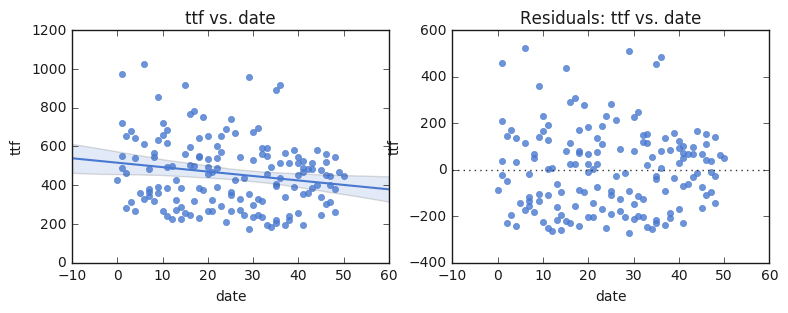

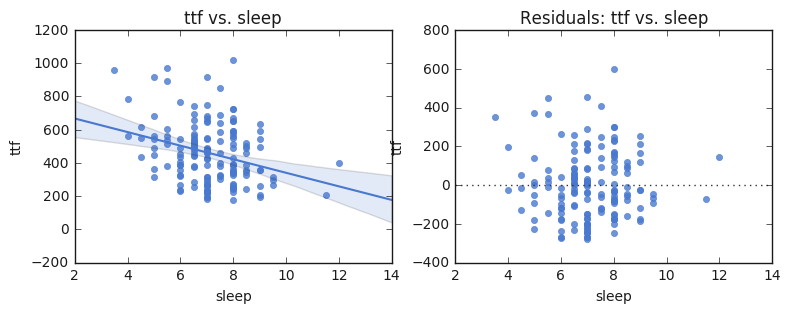

In [247]:
def plot_residuals(x_var, y_var='ttf', color='b'):
    fig = plt.figure(figsize=(9, 3))
    
    plt.subplot(1, 2, 1)
    plt.title('{} vs. {}'.format(y_var, x_var))
    sns.regplot(x=df[x_var], y=df[y_var], color=color)
    
    plt.subplot(1, 2, 2)
    plt.title('Residuals: {} vs. {}'.format(y_var, x_var))
    sns.residplot(x=df[x_var], y=df[y_var], color=color)
    plt.show()
    
plot_residuals('date')
plot_residuals('sleep')

## Building the regression model

In plotting *ttf vs. date* above, we observe a minor correlation between $TTF$ and $Date$, which our original univariate model does not account for. We therefore adjust our model to take the $Date$ variable as a second predictor:

$$TTF = \beta_0 + \beta_1 Sleep + \beta_2 Date + \varepsilon$$

The following table gives the results of fitting this naive regression.

In [232]:
def regress(keys, id_var=None, y_var='ttf'):
    """Computes simple linear regression using the statsmodels OLS API"""
    df_ = df.loc[df['id'] == id_var] if id_var is not None else df
    X = df_[keys]
    y = df_[y_var]
    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()
    return est.summary()

regress(['sleep', 'date'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ttf   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     10.01
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           8.19e-05
Time:                        13:36:00   Log-Likelihood:                -1021.7
No. Observations:                 156   AIC:                             2049.
Df Residuals:                     153   BIC:                             2059.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        793.3986     78.073     10.162      0.000       639.159   947.638
sleep        -39.7905     10.430     -3.815      0.000       -60.396   -19.185
date          -2.1126      0.981     -2.154      0.033        -4.050    -0.175
==============================================================================
Omnibus:                        8.053   Durbin-Watson:                   0.895
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.124
Skew:                           0.557   Prob(JB):                       0.0172
Kurtosis:                       3.090   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [235]:
df['ttf'].max()

1022.0

## Interpreting results

Our $r^2 = 0.116$ value is predictably low, and confirms that our simple two-variable linear model explains relatively little of the overall variance in Sudoku $TTF$.

More interesting are the coefficients $\beta_{Sleep}$ and, to a lesser extent, $\beta_{Date}$:

- $\beta_{Sleep} = -38.7905$, 95% CI $[-60.396, -19.185]$
- $\beta_{Date} = -2.1126$, 95% CI $[-4.050, -0.175]$

$\beta_{Sleep} = -38.7905$ suggests that each additional hour of sleep corresponds to a $TTF$ decrease of about 39 seconds in our model. More broadly, since the 95% CI for $\beta_{Sleep}$ lies strictly below $0$, we can state with 95% confidence that hours of sleep each night correlates with some decrease in Sudoku $TTF$.

To contextualize these coefficients, our observed $TTF$ values range from 175 to 1022 seconds with moderate right skew, and sample mean $\bar{x}_{TTF} = 458.42$. These statistics paint an incomplete picture of the distribution of $TTF$, but they do suggest that a 40-second decrease has moderate practical significance in the context of observed completion times. Collecting additional data would tighten the interval, and allow us to make a stronger statement regarding the impact of sleep on $TTF$.

The 95% CI for $Date$ *also* lies below $0$, but by a much smaller margin. Practical significance is also lower, since each additional day past the start corresponds at *best* to a 4-second improvement, which is easily subsumed by random noise. In this case, additional data collection will not meaningfully change our conclusions.

## Limitations

Our study suffers from major limitations in problem specification and data collection, which in turn limit the extent and utility of further analysis. In short, these limitations are:

- Designing a data collection procedure with too few, inadequately-specified, and insufficiently-granular variables;
- Collecting data over too limited a timeframe to draw conclusions about longitudinal improvement; and
- Differences in Sudoku-solving experience between group members at the start of the experiment.

When we designed our experiment, none of us had learned about multiple regression. Consequently, we did not think to collect any data beyond hours of sleep per night, despite nebulous misgivings that sleep time alone might not adequately explain differences in $TTF$. By the time we covered multiple regression in class, we did not have enough time to collect all-new data.

Furthermore, the sleep data we *did* collect was self-reported in half-hour increments. Self-reporting increased the margin of error, and rounding to half-hour increments did not provide enough granularity to establish a meaningful correlation between sleep time and $TTF$, which was recorded in seconds.

At the beginning of the experiment, one group member had substantially more experience solving Sudoku puzzles than the rest of the group. With only five study participants, these initial skill differences affected the uniformity of data, and the 51-day timeframe was too short for skill levels to converge. Appendix A shows differences in data by group member.

When combined, these limitations imposed a ceiling on our model's expressive power. An insufficient number of input variables, and insufficient variation in their observed values, precluded use of transformed or higher-order predictors. Even with a richer input space, the small number of participants and short experimental timeframe meant a more complex function would likely overfit the available data.

# Conclusions

Based on the 95% CI for $\beta_{Sleep}$, our study supports our alternative hypothesis $H_A: \beta_{Sleep} < 0$. Additional data would help us to determine the practical significance of this correlation. Although aggregate Sudoku-solving performance improved slightly over time, gains were too small to meaningfully inform any behavioral changes.

Major issues with our experimental design and data collection limit the expressive power of our final model. As a result, our study does not yield very many practically interesting conclusions. For instance, a more interesting hypothesis might assess whether the correlation between $Sleep$ and $TTF$ holds for all (practical) values of $Sleep$, or whether the benefits diminish beyond a certain amount of sleep.

In order to support more interesting models, future work should evaluate relationships between $TTF$ and additional factors. 

- Time of day when the puzzle is completed,
- Caffeinated beverages consumed within the 12 hours preceding puzzle completion, and
- Sleep quality.

As always, the decision to study additional variables mandates thoughtful consideration of the specific measurements used. (REM sleep quality and sleep duration, for instance, may not be linearly independent.)

Additional studies should implement at least one of the following measures, in order to control for differences between participants in initial Sudoku-solving experience:

- Having a large number of participants,
- Only studying participants with comparable Sudoku-solving experience,
- Conducting the study over a sufficiently long timeframe, and enforcing uniformity in puzzle completion frequency (rather than leaving frequency to participant discretion).

Finally, results from this study (and any follow-ups) should be interpreted in light of the original premise: measuring Sudoku performance as a proxy for cognitive function. Understanding this relationship far exceeds the scope of our project, but contextualizes the practical implications of any related findings.

# Appendices

## Appendix A: Results by group member

The following charts illustrate differences in $TTF$ data between individual group members. We discuss the implications of these differences in the "Limitations" section above.

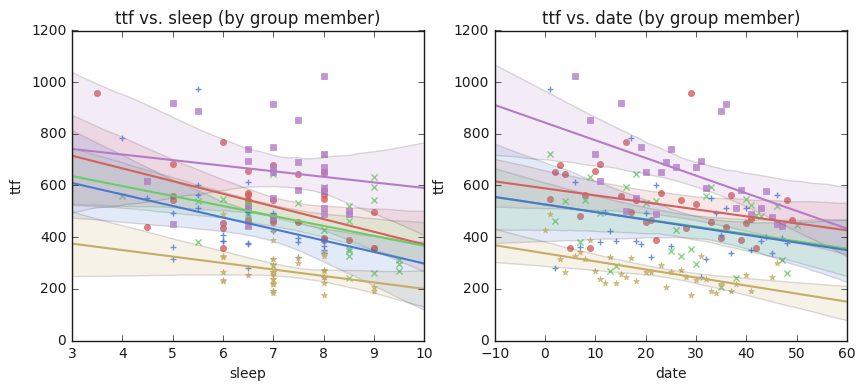

In [246]:
colors = ['r', 'g', 'b', 'y', 'm']
markers = ['o', 'x', '+', '*', ',']

plt.figure(figsize=(10, 4))

for i in range(5):
    df_ = df.loc[df['id'] == i]
    plt.subplot(1, 2, 1)
    plt.title('ttf vs. sleep (by group member)')
    plt.xlabel('sleep (0.5h)')
    plt.ylabel('time to finish (s)')
    sns.regplot(x=df_.sleep,
                y=df_.ttf,
                color=colors[i],
                marker=markers[i])
    
    plt.subplot(1, 2, 2)
    plt.title('ttf vs. date (by group member)')
    plt.xlabel('date')
    sns.regplot(x=df_.date,
                y=df_.ttf, color=colors[i], marker=markers[i])

plt.show()

## Appendix B: Full dataset, sorted by date

In [205]:
df.sort_values('date')

,date,ttf,sleep,id,sleep_log
153,0,427.0,7.0,3,49.00
1,1,548.0,8.0,0,64.00
103,1,973.0,5.5,2,30.25
154,1,489.0,6.0,3,36.00
52,1,722.0,8.0,1,64.00
53,2,462.0,8.5,1,72.25
104,2,282.0,6.5,2,42.25
2,2,654.0,8.0,0,64.00
156,3,314.0,7.0,3,49.00
3,3,680.0,7.0,0,49.00
